### Disclaimer

All hypothesis tests in this notebook will use a significance level ($\alpha$) of **0.05**

In [12]:
# constant
ALPHA = 0.05

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pingouin as pg
from scipy.stats import levene
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [14]:
train = pd.read_csv(r'https://raw.githubusercontent.com/MohamedMostafa259/Customer-Churn-Prediction-and-Analysis/main/Milestone2_FeatureEng_AdvancedAnalysis/data/train_basicFeatureEng.csv')
train.sample(5, random_state=42)

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,...,complaint_status,feedback,churn_risk_score,points_per_transaction,transaction_value_per_time_unit,last_visit_hour,last_visit_time_of_day,last_visit_AMPM,joining_day_name,is_weekend
29946,38,F,City,Gold Membership,2015-12-02,Yes,Gift Vouchers/Coupons,Smartphone,Fiber_Optic,06:16:38,...,Solved in Follow-up,Poor Customer Service,3.0,0.075582,69.531524,6,Morning,AM,Wednesday,0
35510,62,M,Town,No Membership,2017-04-10,No,Without Offers,Desktop,Wi-Fi,11:41:38,...,Not Applicable,Poor Website,4.0,0.006973,1614.092722,11,Morning,AM,Monday,0
17795,29,F,City,Premium Membership,2016-01-03,Yes,Gift Vouchers/Coupons,Smartphone,Mobile_Data,01:23:05,...,Not Applicable,Too many ads,3.0,0.015528,180.974061,1,Night,AM,Sunday,1
1707,63,M,Town,Gold Membership,2016-10-06,Yes,Credit/Debit Card Offers,Smartphone,Fiber_Optic,02:49:30,...,Unsolved,Too many ads,4.0,0.031634,80.902799,2,Night,AM,Thursday,0
12139,60,M,Town,Silver Membership,2017-07-28,Yes,Credit/Debit Card Offers,Desktop,Mobile_Data,14:48:00,...,Not Applicable,Poor Website,3.0,0.261646,23.963007,14,Afternoon,PM,Friday,0


In [15]:
train_copy = train.copy()

In [16]:
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35829 entries, 0 to 35828
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              35829 non-null  int64  
 1   gender                           35829 non-null  object 
 2   region_category                  35829 non-null  object 
 3   membership_category              35829 non-null  object 
 4   joining_date                     35829 non-null  object 
 5   joined_through_referral          35829 non-null  object 
 6   preferred_offer_types            35829 non-null  object 
 7   medium_of_operation              35829 non-null  object 
 8   internet_option                  35829 non-null  object 
 9   last_visit_time                  35829 non-null  object 
 10  days_since_last_login            35829 non-null  float64
 11  avg_time_spent                   35829 non-null  float64
 12  avg_transaction_va

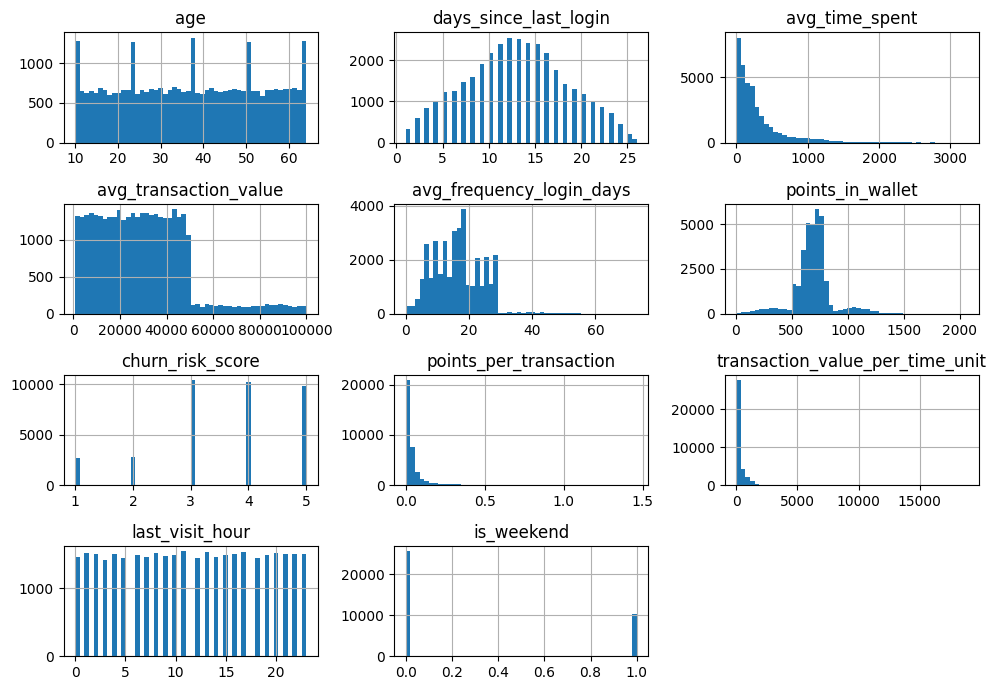

In [17]:
train_copy.hist(bins=50, figsize=(10, 7))
plt.tight_layout()
plt.show()

It's clear that most of the distributions are not normal, but thanks to Central Limit Theorem we still can use parametric tests as our dataset size is large!

### **Oneway ANOVA test** (numerical features vs. churn risk score)

ANOVA test assumes homogeneity of variance, which means that the variance of the feature should be roughly equal across all groups (all churn risk scores). So, let's test that for each numeric column we have using the levene test.

-	If p > 0.05: no significant difference in variance → safe to proceed with ANOVA

-	p <= 0.05: variances significantly differ → use Welch’s correction that doesn't assume equal variance and adjusts the degree of freedom based on that or use non-parametric tests instead (e.g, kruskal).

In [18]:
for num_col in train_copy.select_dtypes('number').columns[:6]:
	groups = [group[num_col] for _, group in train_copy.groupby('churn_risk_score')]
	stat, p_val = levene(*groups)
	print(f'{num_col}: p-value = {p_val:.4f}', end=f', ')
	if p_val > ALPHA:
		print('equal variances')
	else:
		print('unequal variances - WARNING', '!!'*10)

age: p-value = 0.0575, equal variances
days_since_last_login: p-value = 0.2866, equal variances
avg_time_spent: p-value = 0.0002, unequal variances - WARNING !!!!!!!!!!!!!!!!!!!!
avg_transaction_value: p-value = 0.0000, unequal variances - WARNING !!!!!!!!!!!!!!!!!!!!
avg_frequency_login_days: p-value = 0.0000, unequal variances - WARNING !!!!!!!!!!!!!!!!!!!!
points_in_wallet: p-value = 0.0000, unequal variances - WARNING !!!!!!!!!!!!!!!!!!!!


Most columns don't meet the assumption of equal variances, so we'll apply ANOVA to `'age'` and `'days_since_last_login'` columns only.

**Research Question:** Is there a significant difference in the mean value of `'age'` and `'days_since_last_login'` numerical features across the churn risk scores?

$H_0$: The mean of `'age'` and `'days_since_last_login'` numerical features is the same across all churn risk score levels.

$H_1$: At least one group (churn risk score) has a different mean.

In [19]:
for num_col in train_copy.select_dtypes('number').columns[:2]:
	print('-'*30, f'\n{num_col} vs. churn_risk_score')
	print(pg.anova(data=train_copy, dv=num_col, between='churn_risk_score'), '\n')

------------------------------ 
age vs. churn_risk_score
             Source  ddof1  ddof2         F     p-unc       np2
0  churn_risk_score      4  35824  1.648986  0.158871  0.000184 

------------------------------ 
days_since_last_login vs. churn_risk_score
             Source  ddof1  ddof2          F         p-unc       np2
0  churn_risk_score      4  35824  18.021654  8.514888e-15  0.002008 



For `'days_since_last_login'`, let's apply a further analysis (post-hoc test) to investigate which two or more categories have significant differences between their means.

**N.B.** The **family-wise error rate** (FWER) refers to the risk of making one or more **Type I errors** (false positives) when performing multiple statistical tests within a set of comparisons, and methods like **Bonferroni** correction are applied to control this error rate.

In [20]:
pg.pairwise_tests(data=train_copy, dv='days_since_last_login', between='churn_risk_score', padjust='bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,churn_risk_score,1.0,2.0,False,True,0.176026,5389.571066,two-sided,8.602804e-01,1.000000e+00,bonf,0.031,0.004793
1,churn_risk_score,1.0,3.0,False,True,-5.885983,4139.771497,two-sided,4.270252e-09,4.270252e-08,bonf,7.749e+05,-0.127129
2,churn_risk_score,1.0,4.0,False,True,-5.726661,4131.470089,two-sided,1.097041e-08,1.097041e-07,bonf,3.091e+05,-0.124995
3,churn_risk_score,1.0,5.0,False,True,-5.190026,4186.325088,two-sided,2.202302e-07,2.202302e-06,bonf,1.677e+04,-0.113688
4,churn_risk_score,2.0,3.0,False,True,-6.106641,4275.581022,two-sided,1.107916e-09,1.107916e-08,bonf,2.858e+06,-0.131470
5,churn_risk_score,2.0,4.0,False,True,-5.947445,4266.975720,two-sided,2.941565e-09,2.941565e-08,bonf,1.102e+06,-0.129369
6,churn_risk_score,2.0,5.0,False,True,-5.410075,4323.334078,two-sided,6.640357e-08,6.640357e-07,bonf,5.293e+04,-0.118090
7,churn_risk_score,3.0,4.0,False,True,0.252047,20605.152467,two-sided,8.010071e-01,1.000000e+00,bonf,0.016,0.003511
8,churn_risk_score,3.0,5.0,False,True,1.047168,20207.143491,two-sided,2.950347e-01,1.000000e+00,bonf,0.027,0.014717
9,churn_risk_score,4.0,5.0,False,True,0.798247,19984.049772,two-sided,4.247365e-01,1.000000e+00,bonf,0.022,0.011287


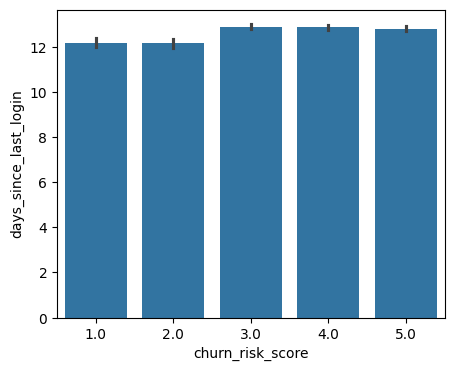

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,churn_risk_score,1.0,2.0,False,True,0.176026,5389.571066,two-sided,8.602804e-01,1.000000e+00,bonf,0.031,0.004793
1,churn_risk_score,1.0,3.0,False,True,-5.885983,4139.771497,two-sided,4.270252e-09,4.270252e-08,bonf,7.749e+05,-0.127129
2,churn_risk_score,1.0,4.0,False,True,-5.726661,4131.470089,two-sided,1.097041e-08,1.097041e-07,bonf,3.091e+05,-0.124995
3,churn_risk_score,1.0,5.0,False,True,-5.190026,4186.325088,two-sided,2.202302e-07,2.202302e-06,bonf,1.677e+04,-0.113688
4,churn_risk_score,2.0,3.0,False,True,-6.106641,4275.581022,two-sided,1.107916e-09,1.107916e-08,bonf,2.858e+06,-0.131470
5,churn_risk_score,2.0,4.0,False,True,-5.947445,4266.975720,two-sided,2.941565e-09,2.941565e-08,bonf,1.102e+06,-0.129369
6,churn_risk_score,2.0,5.0,False,True,-5.410075,4323.334078,two-sided,6.640357e-08,6.640357e-07,bonf,5.293e+04,-0.118090
7,churn_risk_score,3.0,4.0,False,True,0.252047,20605.152467,two-sided,8.010071e-01,1.000000e+00,bonf,0.016,0.003511
8,churn_risk_score,3.0,5.0,False,True,1.047168,20207.143491,two-sided,2.950347e-01,1.000000e+00,bonf,0.027,0.014717
9,churn_risk_score,4.0,5.0,False,True,0.798247,19984.049772,two-sided,4.247365e-01,1.000000e+00,bonf,0.022,0.011287


In [21]:
plt.figure(figsize=(5, 4))
sns.barplot(data=train_copy, x='churn_risk_score', y='days_since_last_login')
plt.show()

pg.pairwise_tests(data=train_copy, dv='days_since_last_login', between='churn_risk_score', padjust='bonf')

In [13]:
num_features = train_copy.select_dtypes('number').columns[:6].tolist()
X = train_copy[num_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_scaled)

# add t-SNE components to the DataFrame
train_copy['tsne-2d-one'] = tsne_results[:, 0]
train_copy['tsne-2d-two'] = tsne_results[:, 1]

In [24]:
train_copy['churn_risk_level'] = train_copy['churn_risk_score'].apply(lambda x: 'low' if x <= 2 else 'high')

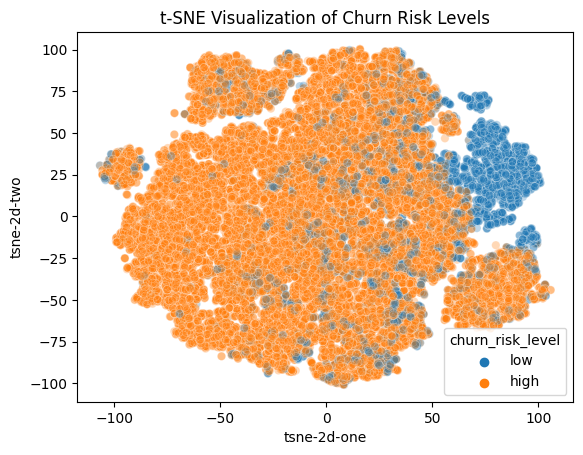

In [ ]:
sns.scatterplot(data=train_copy, x='tsne-2d-one', y='tsne-2d-two', hue='churn_risk_level', alpha=0.3)
plt.title('t-SNE Visualization of Churn Risk Levels')
plt.show()

**Conclusion:**

- For `age`, the p-value > 0.05, so we **fail to reject** $H_0$. There's no significant difference in average age across churn risk scores.

- For `days_since_last_login`, the p-value are all less than 0.05, meaning we **reject** $H_0$. There's statistically significant differences in mean values across churn risk scores.

	-	The pairwise comparisons between churn risk scores and t_SNE visualization of churn risk levels reveal two distinct customer groups based on their login behavior. Customers with risk scores of 1 and 2 show no significant difference in their days_since_last_login, indicating similar recent activity levels and suggesting a low likelihood of churn. In contrast, customers with risk scores of 3, 4, and 5 also show no significant differences among themselves but show a clear and statistically significant difference from those in the 1 and 2 group. This separation implies that risk scores 3, 4, and 5 are associated with customers who have not logged in for longer periods, pointing to a higher risk of churn. Therefore, the churn risk score effectively distinguishes between low-risk (scores 1 and 2) and high-risk (scores 3, 4, and 5) customer segments based on login activity.

### **Two-sample ttest**

We'll apply ttest with Welch's correction to the columns with no equal variance (`avg_time_spent`, `avg_transaction_value`, `avg_frequency_login_days`, and `points_in_wallet`), but now we'll group by the `churn_risk_level`column created below. 

**Research Question:** Do behavioral time spent, transaction value, login frequency, and loyalty points significantly differ between customers with high and low churn risk?

$H_0$: There is no difference in the mean values of the `'avg_time_spent'`, `'avg_transaction_value'`, `'avg_frequency_login_days'`, and `'points_in_wallet'` columns between customers with high and low churn risk

$H_1$: There is a significant difference in at least one of these features between customers with high and low churn risk.

In [22]:
train_copy.select_dtypes('number').columns[2:6].tolist()

['avg_time_spent',
 'avg_transaction_value',
 'avg_frequency_login_days',
 'points_in_wallet']

In [25]:
for num_col in train_copy.select_dtypes('number').columns[2:6]:
	print('-'*30, f'\n{num_col} vs. churn_risk_level')
	print(pg.ttest(
	x=train_copy[train_copy['churn_risk_level'] == 'high'][num_col],
	y=train_copy[train_copy['churn_risk_level'] == 'low'][num_col],
	alternative='two-sided', 
	correction=True
	))

------------------------------ 
avg_time_spent vs. churn_risk_level
              T          dof alternative         p-val             CI95%  \
T-test -7.55403  7251.988753   two-sided  4.736851e-14  [-47.04, -27.66]   

        cohen-d       BF10  power  
T-test  0.11505  3.916e+10    1.0  
------------------------------ 
avg_transaction_value vs. churn_risk_level
               T          dof alternative  p-val                   CI95%  \
T-test -65.32691  5875.712767   two-sided    0.0  [-26682.03, -25127.31]   

         cohen-d BF10  power  
T-test  1.511175  inf    1.0  
------------------------------ 
avg_frequency_login_days vs. churn_risk_level
                T          dof alternative  p-val         CI95%   cohen-d  \
T-test  67.624622  8367.336093   two-sided    0.0  [6.47, 6.86]  0.883075   

       BF10  power  
T-test  inf    1.0  
------------------------------ 
points_in_wallet vs. churn_risk_level
                T         dof alternative  p-val              CI95%   co

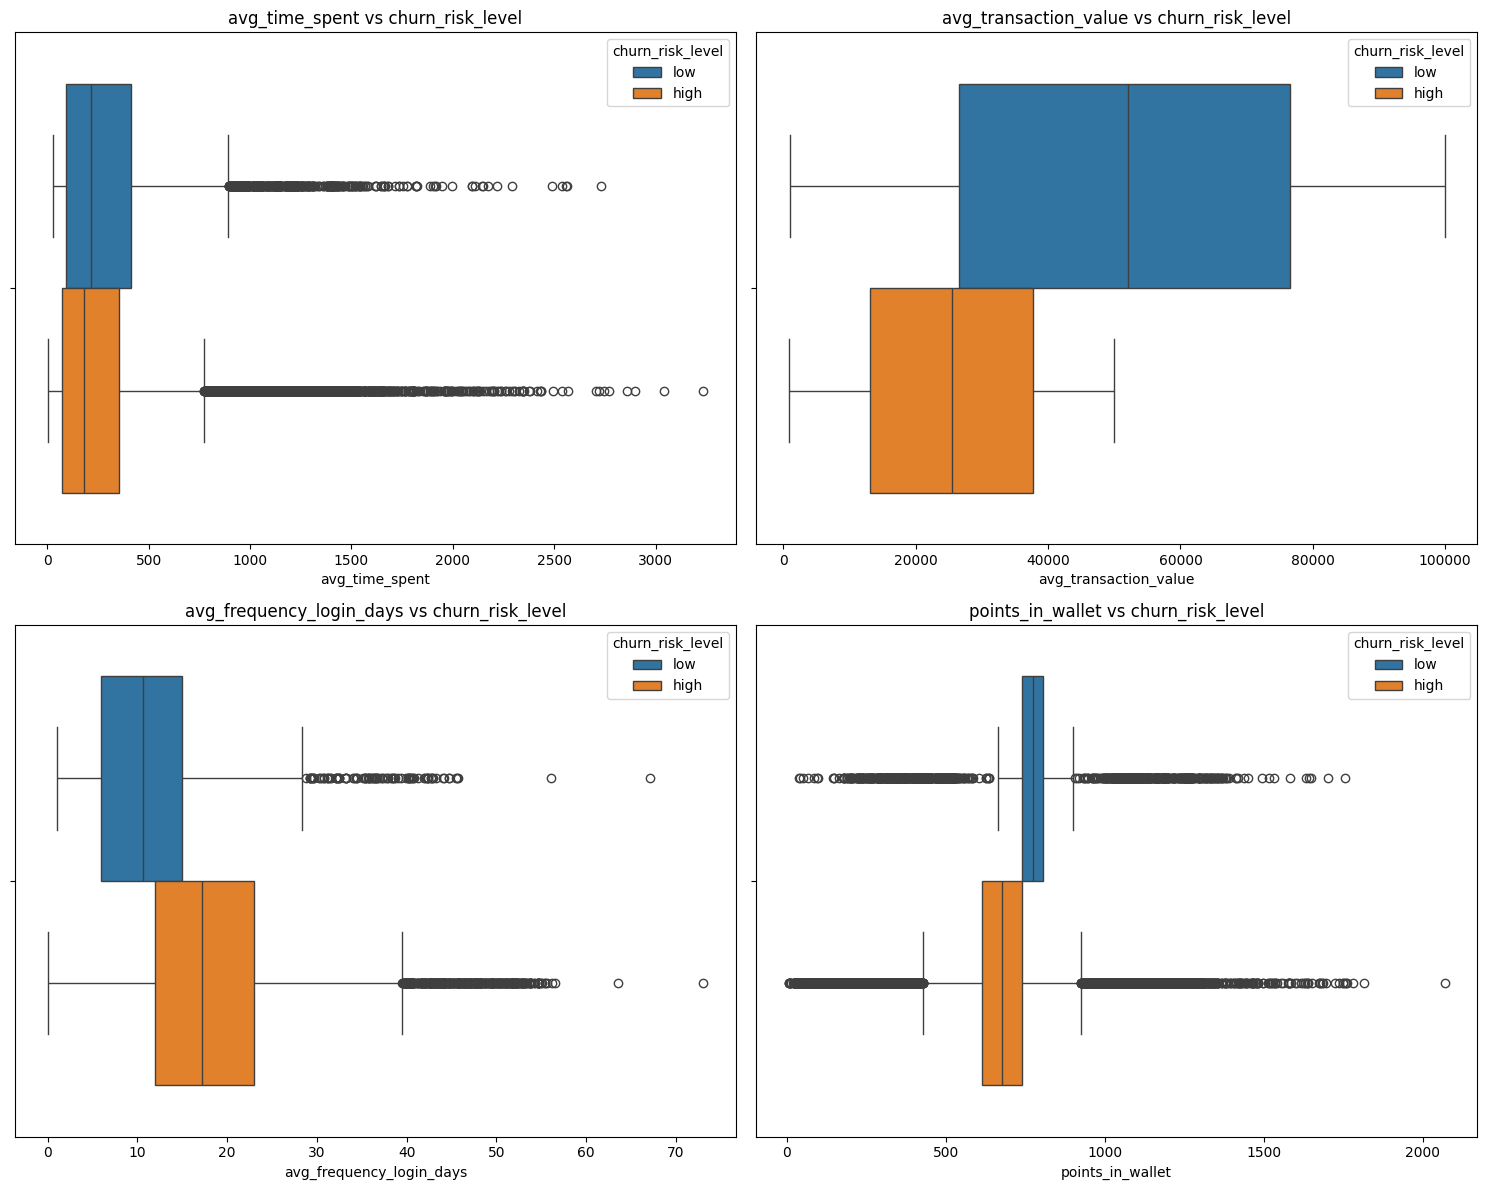

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()  # make it easier to index with a single loop

for idx, col in enumerate(train_copy.select_dtypes('number').columns[2:6]):
	sns.boxplot(data=train_copy, hue='churn_risk_level', x=col, ax=axes[idx])
	axes[idx].set_title(f'{col} vs churn_risk_level')

plt.tight_layout()
plt.show()

**Conclusion:** 

- For all columns: `'avg_time_spent'`, `'avg_transaction_value'`, `'avg_frequency_login_days'`, and `'points_in_wallet'`, the p-value < 0.05, so we **reject** $H_0$ for all of them and conclude that there's no significant difference in their means across churn risk scores.

- High churn risk is consistently linked to lower engagement metrics (time spent, transaction value, loyalty points) but higher login frequency, implying these customers may be encountering service frustrations. 

### **Chi-squared test of independence**

In [27]:
train_copy.select_dtypes(object).columns.tolist()

['gender',
 'region_category',
 'membership_category',
 'joining_date',
 'joined_through_referral',
 'preferred_offer_types',
 'medium_of_operation',
 'internet_option',
 'last_visit_time',
 'used_special_discount',
 'offer_application_preference',
 'past_complaint',
 'complaint_status',
 'feedback',
 'last_visit_time_of_day',
 'last_visit_AMPM',
 'joining_day_name',
 'churn_risk_level']

In [28]:
# extracted from the FeatureEng custom transformer in the FeatureEngineering notebook in milestone 2
positive_feedback = ['Products always in Stock', 'Quality Customer Care', 'Reasonable Price', 'User Friendly Website']
negative_feedback = ['Poor Website', 'Poor Customer Service', 'Poor Product Quality', 'Too many ads']

def get_sentiment(feedback):
	if feedback in positive_feedback:
		return 'positive'
	elif feedback in negative_feedback:
		return 'negative'
	else:
		return 'neutral'
	
train_copy['feedback'] = train_copy['feedback'].apply(get_sentiment)

In [29]:
associated_cols = []
for cat_col in train_copy.select_dtypes(object).columns:
	if cat_col in ['joining_date', 'last_visit_time', 'churn_risk_level']:
		continue
	print('-'*30, f'\n{cat_col} vs. churn_risk_level')
	excepted, observed, stats = pg.chi2_independence(data=train_copy, x='churn_risk_level', y=cat_col)
	print(stats[stats['test'] == 'pearson'], '\n')

	if stats[stats['test'] == 'pearson'].loc[0, 'pval'] <= ALPHA:
		associated_cols.append(cat_col)

------------------------------ 
gender vs. churn_risk_level
      test  lambda     chi2  dof      pval    cramer     power
0  pearson     1.0  0.37016  2.0  0.831038  0.003214  0.078922 

------------------------------ 
region_category vs. churn_risk_level
      test  lambda       chi2  dof          pval    cramer  power
0  pearson     1.0  93.389204  2.0  5.257655e-21  0.051054    1.0 

------------------------------ 
membership_category vs. churn_risk_level


c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8031: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8031: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8028: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


      test  lambda         chi2  dof  pval    cramer  power
0  pearson     1.0  6354.532136  5.0   0.0  0.421138    1.0 

------------------------------ 
joined_through_referral vs. churn_risk_level
      test  lambda        chi2  dof          pval    cramer  power
0  pearson     1.0  230.474817  1.0  4.696705e-52  0.080204    1.0 

------------------------------ 
preferred_offer_types vs. churn_risk_level
      test  lambda        chi2  dof          pval    cramer  power
0  pearson     1.0  316.293701  2.0  2.078239e-69  0.093957    1.0 

------------------------------ 
medium_of_operation vs. churn_risk_level
      test  lambda        chi2  dof          pval    cramer  power
0  pearson     1.0  212.203058  2.0  8.330890e-47  0.076959    1.0 

------------------------------ 
internet_option vs. churn_risk_level
      test  lambda      chi2  dof      pval    cramer     power
0  pearson     1.0  0.727578  2.0  0.695038  0.004506  0.108839 

------------------------------ 
used_special_d

c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\pingouin\contingency.py:151: UserWarning: Low count on observed frequencies.
  warnings.warn(f"Low count on {name} frequencies.")
c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8031: RuntimeWarning: divide by zero encountered in power
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8031: RuntimeWarning: invalid value encountered in multiply
  terms = f_obs * ((f_obs / f_exp)**lambda_ - 1)
c:\Users\moham\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:8028: RuntimeWarning: divide by zero encountered in divide
  terms = 2.0 * special.xlogy(f_exp, f_exp / f_obs)


      test  lambda      chi2  dof      pval    cramer     power
0  pearson     1.0  1.948533  6.0  0.924371  0.007375  0.143315 



In [30]:
print(len(associated_cols))
associated_cols

9


['region_category',
 'membership_category',
 'joined_through_referral',
 'preferred_offer_types',
 'medium_of_operation',
 'offer_application_preference',
 'past_complaint',
 'complaint_status',
 'feedback']

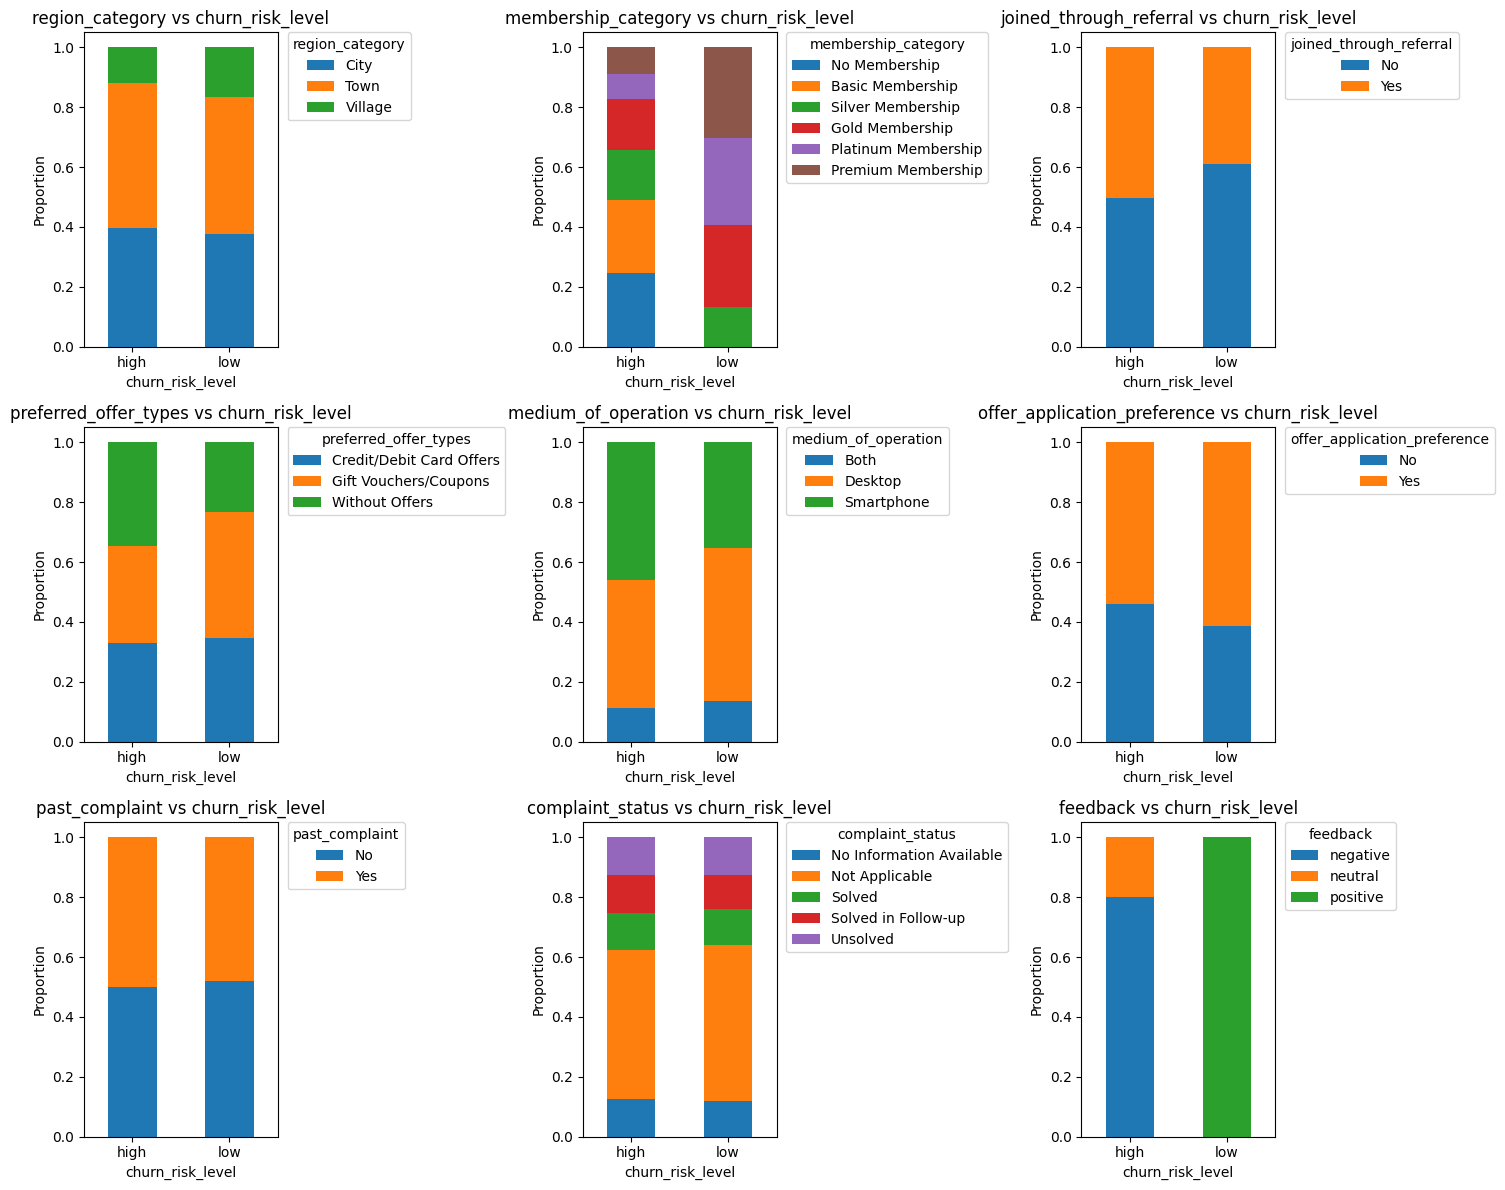

In [31]:
membership_order = ['No Membership', 'Basic Membership', 'Silver Membership',
					'Gold Membership', 'Platinum Membership', 'Premium Membership']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()  # make it easier to index with a single loop

for idx, associated_col in enumerate(associated_cols):
	props = train_copy.groupby('churn_risk_level')[associated_col].value_counts(normalize=True).unstack()

	if associated_col == 'membership_category':
		props = props[membership_order]

	props.plot(kind='bar', stacked=True, rot=0, ax=axes[idx])
	axes[idx].set_title(f'{associated_col} vs churn_risk_level')
	axes[idx].set_ylabel('Proportion')
	# `bbox_to_anchor=(1.05, 1)` places the legend outside the right of the plot
	axes[idx].legend(
		title=associated_col,
		bbox_to_anchor=(1.05, 1),
		loc='upper left',
		borderaxespad=0.
	)

plt.tight_layout()
plt.show()

**Conclusion**:

Among all the associated columns, `membership_category` and `feedback` show the strongest relationship with the `churn_risk_level`.

-	**Membership Category**:

	-	Notably, 0% of customers with low churn risk hold either ‘No Membership’ or ‘Basic Membership’, while these two categories make up a large portion of customers with high churn risk (around 50%).
	
	-	In contrast, Silver, Gold, Platinum, and Premium Memberships are more common among customers with low churn risk.
	
	-	This suggests that higher-tier memberships are associated with lower churn risk, possibly because such customers are more engaged or receive more value from the service.

-	**Feedback**:

	-	100% of customers with low churn risk left positive feedback, with 0% negative or neutral feedback, indicating a strong satisfaction level.
	
	-	On the other hand, customers with high churn risk provided no positive feedback at all—80% gave negative feedback and the remaining 20% gave neutral feedback.
	
	-	This highlights a clear correlation between customer satisfaction and churn risk. Dissatisfied customers (those giving negative or neutral feedback) are far more likely to fall into the high churn risk category.

